In [ ]:
# Notebook to compare GRASP with the forward neural network fw and iv for several synthetic bimodal test cases

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate

import tensorflow as tf

In [2]:
tf.random.set_seed(1234)
np.random.seed(1234)

In [3]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

# Load the forward and inverse model

In [4]:

directoryNN_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_01_12_2022/forward_models_fw/forward_model_fw10_s1'

directoryNN_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_01_12_2022/forward_models_iv/forward_model_iv10_s1'




plot_dir = '/data/project/general/aerosolretriev/aerosol_results_january_2023/bimodal2unimodal'

In [5]:
# Load NN
model_dir = directoryNN_fw  + '/models' 
model_name = 'forward_model/surrogate_model'
model_dir_iv = directoryNN_iv + '/models'

In [6]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}
surr_fw = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name, model_kwargs=kwargs)


# Load the bimodal data

In [7]:
datafile = '/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/datasetbmtomm_qoi.h5'
qoi_test_1 = pd.read_hdf(datafile,key='qoi1')
qoi_test_2 = pd.read_hdf(datafile,key='qoi2')
qoi_test = pd.read_hdf(datafile,key='qoi')
dvar_test_1 = pd.read_hdf(datafile,key='dvar1')
dvar_test_2 = pd.read_hdf(datafile,key='dvar2')

In [8]:
# Transform the phase function data

In [9]:
F11_list = [x for x in qoi_test.columns if 'F11'in x]

In [10]:
column_list = []
F11_list = []
F12_list = []
PPF_list = []
for i in range(10,86):
    column_list.append('F11_'+str(i))
    F11_list.append('F11_'+str(i))
    F12_list.append('F12_'+str(i))
for i in range(95,171):
    column_list.append('F11_'+str(i))
    F11_list.append('F11_'+str(i))
    F12_list.append('F12_'+str(i))
for i in range(10,86):
    column_list.append('PPF_'+str(i))
    PPF_list.append('PPF_'+str(i))
for i in range(95,171):
    column_list.append('PPF_'+str(i))
    PPF_list.append('PPF_'+str(i))

In [11]:
PPF_test_1 = -(qoi_test_1[F12_list].values)/(qoi_test_1[F11_list].values)
PPF_test_1 = pd.DataFrame(PPF_test_1, columns = PPF_list)
PPF_test_1
PPF_test_2 = -(qoi_test_2[F12_list].values)/(qoi_test_2[F11_list].values)
PPF_test_2 = pd.DataFrame(PPF_test_2, columns = PPF_list)


In [12]:
len(column_list)

304

In [13]:
qoi_test['F11_170']= qoi_test['F11_169']
qoi_test['PPF_170']= qoi_test['PPF_169']


# Load GRASP retrieval results

In [14]:
# GRASP F_11 and PPF
datafileGRASP_F11PPF = '/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_16_08_2022/Bimodal2Unimodal_GRASP_P11P12.h5'

dvar_predGRASP_F11PPF = pd.read_hdf(datafileGRASP_F11PPF,key='dvar')
qoi_predGRASP_F11PPF = pd.read_hdf(datafileGRASP_F11PPF,key='qoi')

dvar_predGRASP_F11PPF_mode_1 = pd.read_hdf(datafileGRASP_F11PPF,key='dvar1')
dvar_predGRASP_F11PPF_mode_2 =pd.read_hdf(datafileGRASP_F11PPF,key='dvar2')

qoi_predGRASP_F11PPF_mode_1 = pd.read_hdf(datafileGRASP_F11PPF,key='qoi1')
qoi_predGRASP_F11PPF_mode_2 =pd.read_hdf(datafileGRASP_F11PPF,key='qoi2')

In [15]:
qoi_predGRASP_F11PPF['F11_85'] = qoi_predGRASP_F11PPF['F11_84']
qoi_predGRASP_F11PPF['F11_95'] = qoi_predGRASP_F11PPF['F11_96']
qoi_predGRASP_F11PPF['PPF_85'] = qoi_predGRASP_F11PPF['PPF_84']
qoi_predGRASP_F11PPF['PPF_95'] = qoi_predGRASP_F11PPF['PPF_96']


In [16]:
column_list = np.concatenate([F11_list, PPF_list])

In [17]:
qoi_predGRASP = qoi_predGRASP_F11PPF[column_list]

In [18]:
qoi_predGRASP[F11_list] = qoi_predGRASP[F11_list]/ (4*np.pi) * 1e+12 
#qoi_predGRASP_F11PPF_mode_1[F11_list] = qoi_predGRASP_F11PPF_mode_1[F11_list]/ (4*np.pi) * 1e+12
#qoi_predGRASP_F11PPF_mode_2[F11_list] = qoi_predGRASP_F11PPF_mode_2[F11_list]/ (4*np.pi) * 1e+12

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# Predict aerosol properties with NN

In [19]:
qoi_test_copy = qoi_test.copy()
qoi_test_copy[F11_list]=np.log(qoi_test_copy[F11_list])

In [20]:
dvar_pred = surr_fw.predict(qoi_test_copy[column_list].values)

In [21]:
dvar_pred = pd.DataFrame(dvar_pred, columns = dvar_test_1.columns)

In [22]:
dvar_pred_final = dvar_pred.copy()
dvar_pred_final = np.exp(dvar_pred_final)
dvar_pred_final['GSD'] = dvar_pred_final['GSD']+1
dvar_pred_final['n']=dvar_pred_final['n']+1.33



# Predict F11 with NN for predicted parameter properties

In [23]:
# be careful for prediction R_median must be in um
dvar_pred_copy = dvar_pred.copy()


In [24]:
qoi_pred_INN = surr_iv.predict(dvar_pred_copy)

In [25]:
qoi_pred_INN = pd.DataFrame(qoi_pred_INN, columns = column_list)


In [26]:
qoi_pred_INN[F11_list] = np.exp(qoi_pred_INN[F11_list])

# Predict F11 with NN for monomodal parameter properties

In [27]:
dvar_test_1_copy = dvar_test_1.copy()
dvar_test_1_copy['RmedianV']= dvar_test_1_copy['RmedianV']*1e-3


dvar_test_1_copy['GSD']= dvar_test_1_copy['GSD']-1
dvar_test_1_copy['n']= dvar_test_1_copy['n']-1.33
dvar_test_1_copy = np.log(dvar_test_1_copy)
dvar_test_2_copy = dvar_test_2.copy()
dvar_test_2_copy['RmedianV']= dvar_test_2_copy['RmedianV']*1e-3
dvar_test_2_copy['GSD']= dvar_test_2_copy['GSD']-1
dvar_test_2_copy['n']= dvar_test_2_copy['n']-1.33

dvar_test_2_copy = np.log(dvar_test_2_copy)

In [28]:
qoi_pred_INN_dvar_test_1 = surr_iv.predict(dvar_test_1_copy)
qoi_pred_INN_dvar_test_2 = surr_iv.predict(dvar_test_2_copy)
qoi_pred_INN_dvar_test_1 = pd.DataFrame(qoi_pred_INN_dvar_test_1, columns = column_list)
qoi_pred_INN_dvar_test_2 = pd.DataFrame(qoi_pred_INN_dvar_test_2, columns = column_list)


In [29]:
qoi_pred_INN_dvar_test_1[F11_list]=np.exp(qoi_pred_INN_dvar_test_1[F11_list])
qoi_pred_INN_dvar_test_2[F11_list]=np.exp(qoi_pred_INN_dvar_test_2[F11_list])

# Predict parameter properties from monomodal cases only F11

In [30]:
qoi_test_1[F11_list]=np.log(qoi_test_1[F11_list])
qoi_test_2[F11_list]=np.log(qoi_test_2[F11_list])

In [31]:
qoi_test_1_F11 = qoi_test_1[F11_list].copy()
qoi_test_2_F11 = qoi_test_2[F11_list].copy()

In [32]:
qoi_test_2pred_1 = pd.concat([qoi_test_1_F11,PPF_test_1],axis = 1) 
qoi_test_2pred_2 = pd.concat([qoi_test_2_F11,PPF_test_2],axis = 1) 

In [33]:
#qoi_test_1 = qoi_test_1 * (4*np.pi) / 1e+12
#qoi_test_2 = qoi_test_2 * (4*np.pi) / 1e+12

In [34]:
dvar_pred_qoi_test_1 = surr_fw.predict(qoi_test_2pred_1.values)
dvar_pred_qoi_test_2 = surr_fw.predict(qoi_test_2pred_2.values)


In [35]:
dvar_pred_qoi_test_1 = pd.DataFrame(dvar_pred_qoi_test_1, columns = dvar_test_1.columns)
dvar_pred_qoi_test_2 = pd.DataFrame(dvar_pred_qoi_test_2, columns = dvar_test_1.columns)


In [36]:
dvar_pred_qoi_test_1 = np.exp(dvar_pred_qoi_test_1)
dvar_pred_qoi_test_1['GSD']=dvar_pred_qoi_test_1['GSD']+1
dvar_pred_qoi_test_1['n']=dvar_pred_qoi_test_1['n']+1.33

dvar_pred_qoi_test_1['RmedianV']=dvar_pred_qoi_test_1['RmedianV']*1e-3
dvar_pred_qoi_test_2 = np.exp(dvar_pred_qoi_test_2)
dvar_pred_qoi_test_2['GSD']=dvar_pred_qoi_test_2['GSD']+1
dvar_pred_qoi_test_2['n']=dvar_pred_qoi_test_2['n']+1.33
dvar_pred_qoi_test_2['RmedianV']=dvar_pred_qoi_test_2['RmedianV']*1e-3

# Comparison plots size distributions

In [37]:
dvar_pred = np.exp(dvar_pred)
dvar_pred['GSD']=dvar_pred['GSD']+1
dvar_pred['n']=dvar_pred['n']+1.33

#dvar_pred['RmedianV']=dvar_pred['RmedianV']*1e-3


# Recompute phase fucntions from predicted aerosol properties:


In [38]:
dvar_pred.to_hdf('/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/test_cases_pred_INN13.h5', key = 'dvar')
qoi_pred_INN.to_hdf('/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/test_cases_pred_INN13.h5', key = 'qoi')




In [39]:
dvar_pred_qoi_test_1.to_hdf('/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/test_cases_pred_INN13.h5', key = 'dvar1')
dvar_pred_qoi_test_2.to_hdf('/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/test_cases_pred_INN13.h5', key = 'dvar2')

qoi_pred_INN_dvar_test_1.to_hdf('/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/test_cases_pred_INN13.h5', key = 'qoi1')
qoi_pred_INN_dvar_test_2.to_hdf('/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/test_cases_pred_INN13.h5', key = 'qoi2')


In [40]:
#run Dataset_Create_PyMieScatt_unimodal.py --datafile_input '/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/test_cases_pred_INN13.h5' --datafile_output '/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/test_cases_pred_INN_PMS.h5'


# Comparison plots phase functions

In [41]:
datafile = '/data/project/general/aerosolretriev/aerosol_data/bimodal_to_monomodal_12_01_2023/test_cases_pred_INN_PMS.h5'
qoi_pred_pred = pd.read_hdf(datafile,key='qoi')
dvar_pred_pred  = pd.read_hdf(datafile, key= 'dvar')

In [42]:
# create vector with angles according to NN
angles_NN_1 = np.arange(10,86)
angles_NN_2 = np.arange(95, 171)
angles_NN = np.concatenate((angles_NN_1.T, angles_NN_2.T))
theta = angles_NN

In [43]:
theta

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170])

In [44]:
F11_list =[]
total_list = []
for i in range(5,85):
    F11_list.append('F11_'+str(i))
    total_list.append('F11_'+str(i))
for i in range(96,176):
    F11_list.append('F11_'+str(i))
    total_list.append('F11_'+str(i))
F12_list =[]
PPF_list = []
for i in range(5,85):
    F12_list.append('F12_'+str(i))
    total_list.append('PPF_'+str(i))
    PPF_list.append('PPF_'+str(i))
for i in range(96,176):
    F12_list.append('F12_'+str(i))
    total_list.append('PPF_'+str(i))
    PPF_list.append('PPF_'+str(i))

In [45]:
theta

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170])

In [46]:
qoi_pred_pred.isnull().sum().sum()
qoi_pred_INN.isnull().sum().sum()
qoi_test.isnull().sum().sum()

0

In [47]:
F11_list_1 = [x for x in qoi_pred_INN.columns if 'F11' in x]
F12_list_1 = [x for x in qoi_pred_pred.columns if 'F12' in x]
PPF_list_1 = [x for x in qoi_pred_INN.columns if 'PPF' in x]

In [48]:
F12_list_1 = F11_list_1.copy()
#F12_list_1 = np.array(F12_list_1).str.replace(r'F11_', 'F12_')


F12_list_1 = [w.replace('F11_', 'F12_') for w in F12_list_1]
F12_list_1

['F12_10',
 'F12_11',
 'F12_12',
 'F12_13',
 'F12_14',
 'F12_15',
 'F12_16',
 'F12_17',
 'F12_18',
 'F12_19',
 'F12_20',
 'F12_21',
 'F12_22',
 'F12_23',
 'F12_24',
 'F12_25',
 'F12_26',
 'F12_27',
 'F12_28',
 'F12_29',
 'F12_30',
 'F12_31',
 'F12_32',
 'F12_33',
 'F12_34',
 'F12_35',
 'F12_36',
 'F12_37',
 'F12_38',
 'F12_39',
 'F12_40',
 'F12_41',
 'F12_42',
 'F12_43',
 'F12_44',
 'F12_45',
 'F12_46',
 'F12_47',
 'F12_48',
 'F12_49',
 'F12_50',
 'F12_51',
 'F12_52',
 'F12_53',
 'F12_54',
 'F12_55',
 'F12_56',
 'F12_57',
 'F12_58',
 'F12_59',
 'F12_60',
 'F12_61',
 'F12_62',
 'F12_63',
 'F12_64',
 'F12_65',
 'F12_66',
 'F12_67',
 'F12_68',
 'F12_69',
 'F12_70',
 'F12_71',
 'F12_72',
 'F12_73',
 'F12_74',
 'F12_75',
 'F12_76',
 'F12_77',
 'F12_78',
 'F12_79',
 'F12_80',
 'F12_81',
 'F12_82',
 'F12_83',
 'F12_84',
 'F12_85',
 'F12_95',
 'F12_96',
 'F12_97',
 'F12_98',
 'F12_99',
 'F12_100',
 'F12_101',
 'F12_102',
 'F12_103',
 'F12_104',
 'F12_105',
 'F12_106',
 'F12_107',
 'F12_108',
 

In [56]:
D_array = np.logspace(0.1, 5, 300)

# Plots for Case 2: changing n

In [49]:
cases_n = [0,1,2,3,4,5,6]
xax = (dvar_test_2['n']-dvar_test_1['n'])[0:7].values

In [50]:
import matplotlib.gridspec as gridspec

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


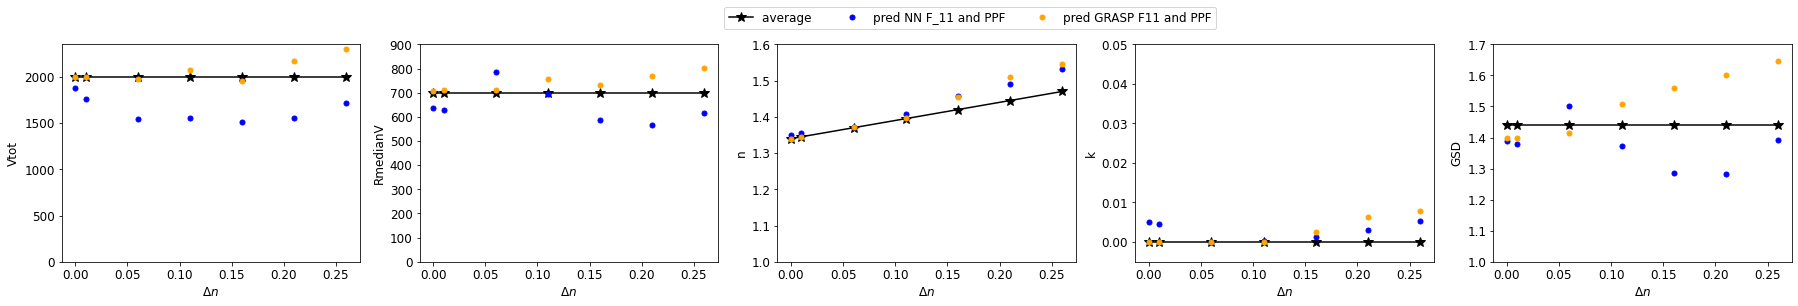

In [51]:
fs = 12
ms = 10
fsl = 15
name = 'n'

fig = plt.figure(tight_layout=True,figsize=(31,4))
gs = gridspec.GridSpec(1, 5)
number = 0
for name in dvar_test_1.columns:

    if name == 'Vtot':
        ax = fig.add_subplot(gs[0, 0])   

        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n]),'k',markersize = ms,  marker = '*', label = 'V_tot1+V_tot2')
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '.',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'orange', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)

        ax.set_xlabel('$\Delta n$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)
        ax.set_ylim(0,2350)

    else:
        if name == 'RmedianV':
            ax = fig.add_subplot(gs[0, 1]) 
            ax.set_ylim(0,900)
        if name == 'GSD':
            ax = fig.add_subplot(gs[0, 4]) 
            ax.set_ylim(1.0,1.7)
        if name == 'n':
            ax = fig.add_subplot(gs[0, 2])
            ax.set_ylim(1.0,1.6)
        if name == 'k':
            ax = fig.add_subplot(gs[0, 3])
            ax.set_ylim(-0.005,0.05)
        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n])/2.,'k', markersize = ms,  marker = '*', label = 'average ') 
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '.',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'orange', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)
        if number == 2:
            ax.legend(fontsize = fs, loc='upper left', bbox_to_anchor=(1, 1.2), ncol = 5 )

        ax.set_xlabel('$\Delta n$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)

            
     

<ipython-input-52-accfa3913f12>:52: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.savefig(f'{plot_dir}/case2_changing_n_parameters.jpg')
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


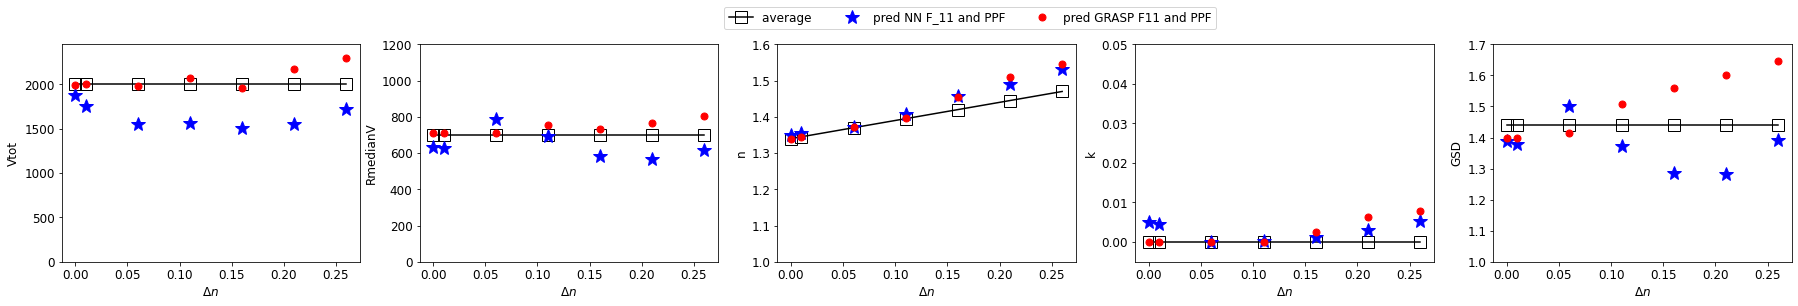

In [52]:
fs = 12
ms = 14
ms1 = 12
ms2 = 14
fsl = 15
name = 'n'

fig = plt.figure(tight_layout=True,figsize=(31,4))
gs = gridspec.GridSpec(1, 5)
number = 0
for name in dvar_test_1.columns:

    if name == 'Vtot':
        ax = fig.add_subplot(gs[0, 0])   

        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n]),'k',markersize = ms1,  marker = 's', label = 'V_tot1+V_tot2', fillstyle = 'none')
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '*',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms2 )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'red', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)

        ax.set_xlabel('$\Delta n$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)
        ax.set_ylim(0,2450)

    else:
        if name == 'RmedianV':
            ax = fig.add_subplot(gs[0, 1]) 
            ax.set_ylim(0,1200)
        if name == 'GSD':
            ax = fig.add_subplot(gs[0, 4]) 
            ax.set_ylim(1.0,1.7)
        if name == 'n':
            ax = fig.add_subplot(gs[0, 2])
            ax.set_ylim(1.0,1.6)
        if name == 'k':
            ax = fig.add_subplot(gs[0, 3])
            ax.set_ylim(-0.005,0.05)
        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n])/2.,'k', markersize = ms1,  marker = 's', label = 'average ', fillstyle='none') 
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '*',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms2 )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'red', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)
        if number == 2:
            ax.legend(fontsize = fs, loc='upper left', bbox_to_anchor=(1, 1.2), ncol = 5 )

        ax.set_xlabel('$\Delta n$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)

fig.savefig(f'{plot_dir}/case2_changing_n_parameters.jpg')


In [53]:
F11_list = [x for x in qoi_test.columns if 'F11' in x]
PPF_list = [x for x in qoi_test.columns if 'PPF' in x]


In [54]:
def compute_v(dvar_values, D_array):
    V_tot, R_median_V, GSD, ri_n, ri_k = dvar_values
    D_median_V = R_median_V*2  # [nm]
#    print(D_median_V)
    D_median_N = (np.exp(np.log(D_median_V) - (3*np.log(GSD)**2)))      # [nm]
#    print(D_median_N)
    N_tot = 6 / np.pi * V_tot*1e9 / (np.exp((3*np.log(D_median_N)) + (4.5*np.log(GSD)**2))) # [cm^-3]

    ndvar = lognormal(D_array, D_median_N , GSD, N_tot) *D_array    
   
    vdvar =  ndvar*4/3*np.pi*(D_array/2.)**3.
    return vdvar

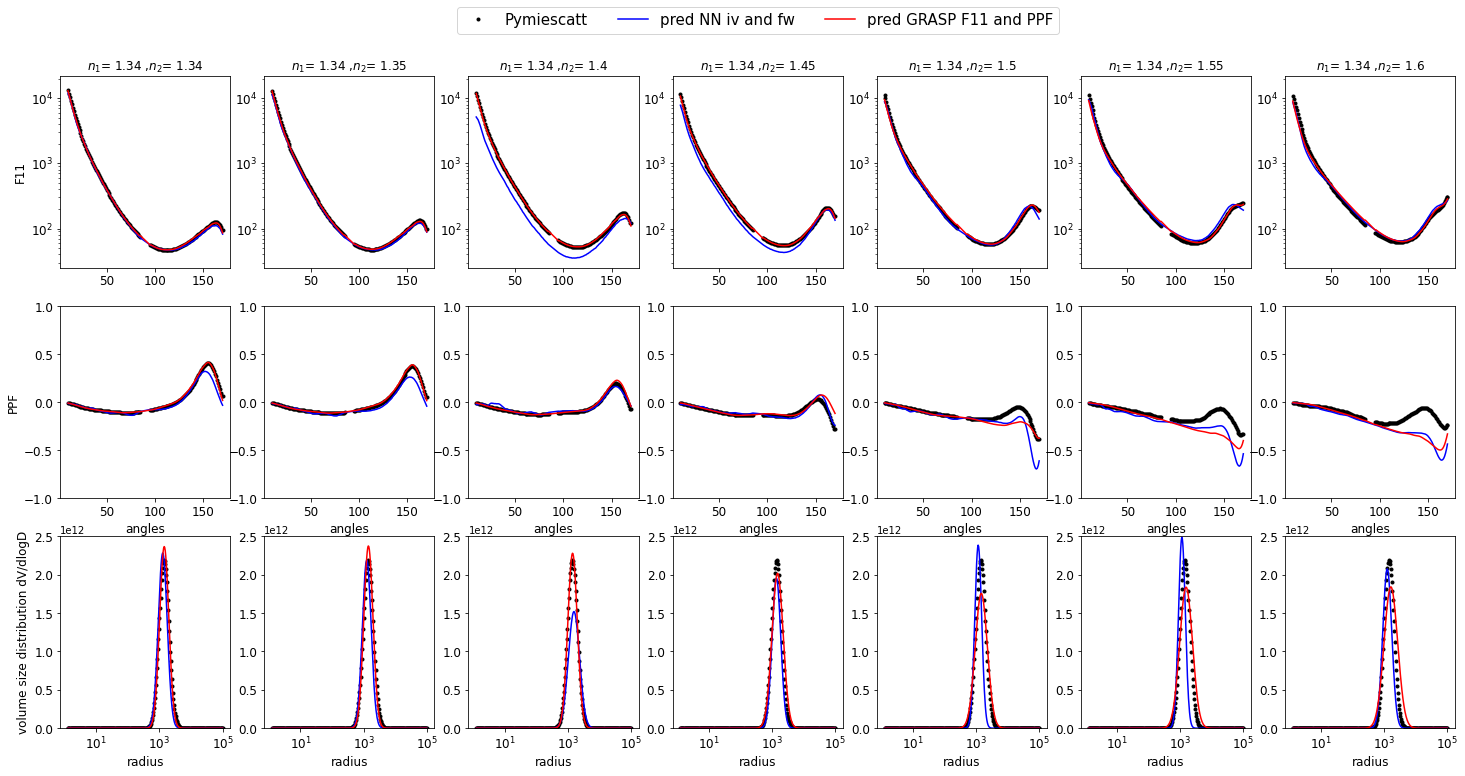

In [57]:


        
        

fig = plt.figure(figsize=(25,12))

gs = gridspec.GridSpec(3,7)
for index in cases_n:
    ax = fig.add_subplot(gs[0,index])
    ax.plot(theta, qoi_test[F11_list].loc[index], 'k.',label='Pymiescatt')
    ax.plot(theta, qoi_pred_INN[F11_list].loc[index],'b', label='pred NN iv and fw')
    ax.plot(theta, qoi_predGRASP_F11PPF[F11_list].loc[index]*1e12/4/np.pi,color = 'r', label = 'pred GRASP F11 and PPF')

    ax.set_yscale('log')
    ax.set_ylim(25,22000)
    if index ==0:
        ax.set_ylabel('F11')
    ax.set_title('$n_1$= '+str(dvar_test_1['n'].loc[index])+' ,$n_2$= '+str(dvar_test_2['n'].loc[index]))
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    if index ==3:
        
        ax.legend(fontsize = fsl,     loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol = 5)
        
    ax = fig.add_subplot(gs[1, index])
    ax.plot(theta, qoi_test[PPF_list].loc[index], 'k.',label='Pymiescatt')
    ax.plot(theta, qoi_pred_INN[PPF_list].loc[index],'b', label='pred NN iv and  fw')
    ax.plot(theta, qoi_predGRASP_F11PPF[PPF_list].loc[index],color = 'r', label = 'pred GRASP F11 and PPF')
    ax.set_xlabel('angles')
    if index ==0:
        ax.set_ylabel('PPF')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.set_ylim(-1,1)
    
    vdvar_test_1 = compute_v(dvar_test_1.loc[index].values, D_array)
    vdvar_test_2 = compute_v(dvar_test_2.loc[index].values, D_array)
    
    vdvar_pred_final  = compute_v(dvar_pred_final.loc[index].values, D_array)       
    
    vdvar_GRASP_F11PPF = compute_v(dvar_predGRASP_F11PPF.loc[index].values, D_array)
  
  

    ax = fig.add_subplot(gs[2, index])
    ax.plot(D_array,vdvar_test_1+vdvar_test_2 ,'k.',label = 'bimodal')
    ax.plot(D_array,vdvar_pred_final,'b',label = 'pred INN F_11 and PPF')
    ax.plot(D_array, vdvar_GRASP_F11PPF,color = 'r', label = 'pred GRASP F11 and PPF')
    ax.set_ylim(0,2.5*1e12)
    ax.set_xscale('log')
    ax.set_xlabel('radius')
    if index ==0:
        ax.set_ylabel('volume size distribution dV/dlogD')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    
# Case2 - changing n
fig.savefig(f'{plot_dir}/case2_changing_n_all.jpg')


# Plots for Case 1a: changing R2

In [58]:
cases_n = [7,8,9,10,11,12,13,14]
xax = (dvar_test_2['RmedianV']/dvar_test_1['RmedianV'])[7:15].values

<ipython-input-59-5a60f2d35dde>:52: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.savefig(f'{plot_dir}/case1a_changing_R_parameters.jpg')
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


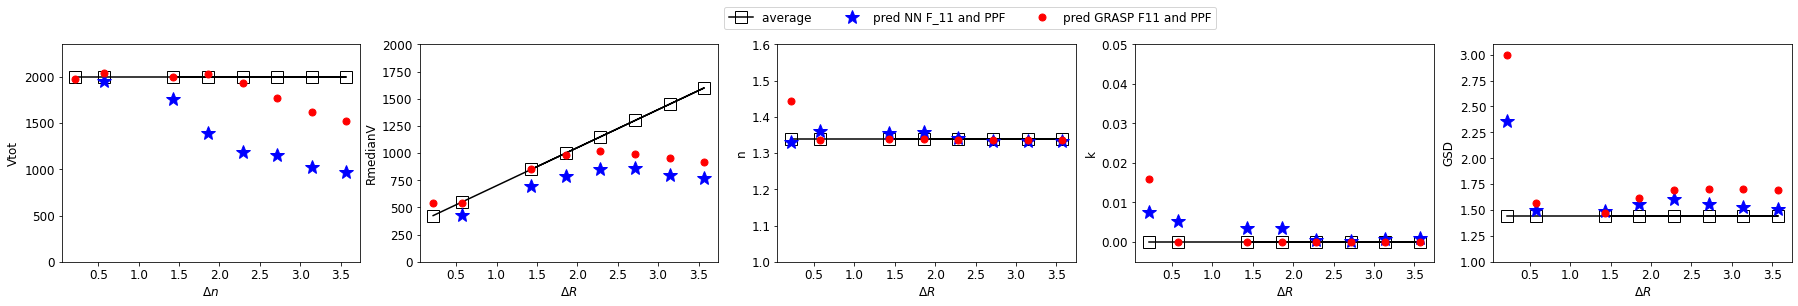

In [59]:
fs = 12
ms = 14
ms1 = 12
ms2 = 14
fsl = 15
name = 'n'

fig = plt.figure(tight_layout=True,figsize=(31,4))
gs = gridspec.GridSpec(1, 5)
number = 0
for name in dvar_test_1.columns:

    if name == 'Vtot':
        ax = fig.add_subplot(gs[0, 0])   

        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n]),'k',markersize = ms1,  marker = 's', label = 'V_tot1+V_tot2', fillstyle = 'none')
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '*',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms2 )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'red', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)

        ax.set_xlabel('$\Delta n$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)
        ax.set_ylim(0,2350)

    else:
        if name == 'RmedianV':
            ax = fig.add_subplot(gs[0, 1]) 
            ax.set_ylim(0,2000)
        if name == 'GSD':
            ax = fig.add_subplot(gs[0, 4]) 
            ax.set_ylim(1.0,3.1)
        if name == 'n':
            ax = fig.add_subplot(gs[0, 2])
            ax.set_ylim(1.0,1.6)
        if name == 'k':
            ax = fig.add_subplot(gs[0, 3])
            ax.set_ylim(-0.005,0.05)
        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n])/2.,'k', markersize = ms1,  marker = 's', label = 'average ', fillstyle='none') 
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '*',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms2 )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'red', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)
        if number == 2:
            ax.legend(fontsize = fs, loc='upper left', bbox_to_anchor=(1, 1.2), ncol = 5 )

        ax.set_xlabel('$\Delta R$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)

fig.savefig(f'{plot_dir}/case1a_changing_R_parameters.jpg')


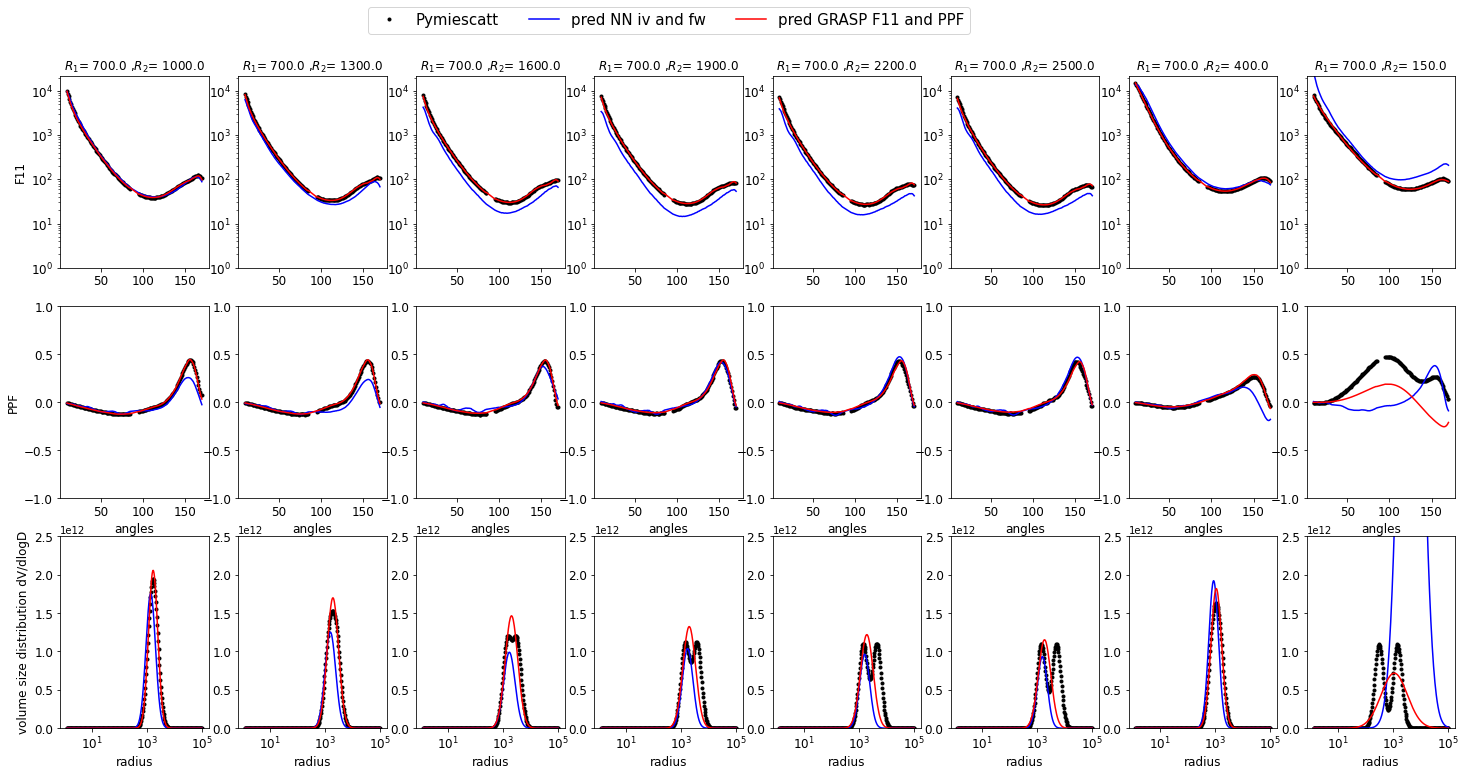

In [60]:


        
        

fig = plt.figure(figsize=(25,12))
number = 0
gs = gridspec.GridSpec(3,8)
for index in cases_n:
    ax = fig.add_subplot(gs[0,number])
    ax.plot(theta, qoi_test[F11_list].loc[index], 'k.',label='Pymiescatt')
    ax.plot(theta, qoi_pred_INN[F11_list].loc[index],'b', label='pred NN iv and fw')
    ax.plot(theta, qoi_predGRASP_F11PPF[F11_list].loc[index]*1e12/4/np.pi,color = 'r', label = 'pred GRASP F11 and PPF')

    ax.set_yscale('log')
    ax.set_ylim(1,22000)
    if number ==0:
        ax.set_ylabel('F11')
    ax.set_title('$R_1$= '+str(dvar_test_1['RmedianV'].loc[index])+' ,$R_2$= '+str(dvar_test_2['RmedianV'].loc[index]))
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    if number ==3:
        
        ax.legend(fontsize = fsl,     loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol = 5)
        
    ax = fig.add_subplot(gs[1, number])
    ax.plot(theta, qoi_test[PPF_list].loc[index], 'k.',label='Pymiescatt')
    ax.plot(theta, qoi_pred_INN[PPF_list].loc[index],'b', label='pred NN iv and  fw')
    ax.plot(theta, qoi_predGRASP_F11PPF[PPF_list].loc[index],color = 'r', label = 'pred GRASP F11 and PPF')
    ax.set_xlabel('angles')
    if number ==0:
        ax.set_ylabel('PPF')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.set_ylim(-1,1)
    
    vdvar_test_1 = compute_v(dvar_test_1.loc[index].values, D_array)
    vdvar_test_2 = compute_v(dvar_test_2.loc[index].values, D_array)
    
    vdvar_pred_final  = compute_v(dvar_pred_final.loc[index].values, D_array)       
    
    vdvar_GRASP_F11PPF = compute_v(dvar_predGRASP_F11PPF.loc[index].values, D_array)
  
  

    ax = fig.add_subplot(gs[2, number])
    ax.plot(D_array,vdvar_test_1+vdvar_test_2 ,'k.',label = 'bimodal')
    ax.plot(D_array,vdvar_pred_final,'b',label = 'pred INN F_11 and PPF')
    ax.plot(D_array, vdvar_GRASP_F11PPF,color = 'r', label = 'pred GRASP F11 and PPF')
    ax.set_ylim(0,2.5*1e12)
    ax.set_xscale('log')
    ax.set_xlabel('radius')
    if number ==0:
        ax.set_ylabel('volume size distribution dV/dlogD')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    number = number +1
# Case2 - changing n
fig.savefig(f'{plot_dir}/case1a_changing_R_all.jpg')


# Plots for Case 1b: changing R2|

In [61]:
cases_n = [15,16,17,18,19,20,21,22,23]
xax = (dvar_test_2['RmedianV']/dvar_test_1['RmedianV'])[15:24].values

<ipython-input-62-804cf141d51c>:52: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.savefig(f'{plot_dir}/case1b_changing_R_parameters.jpg')
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


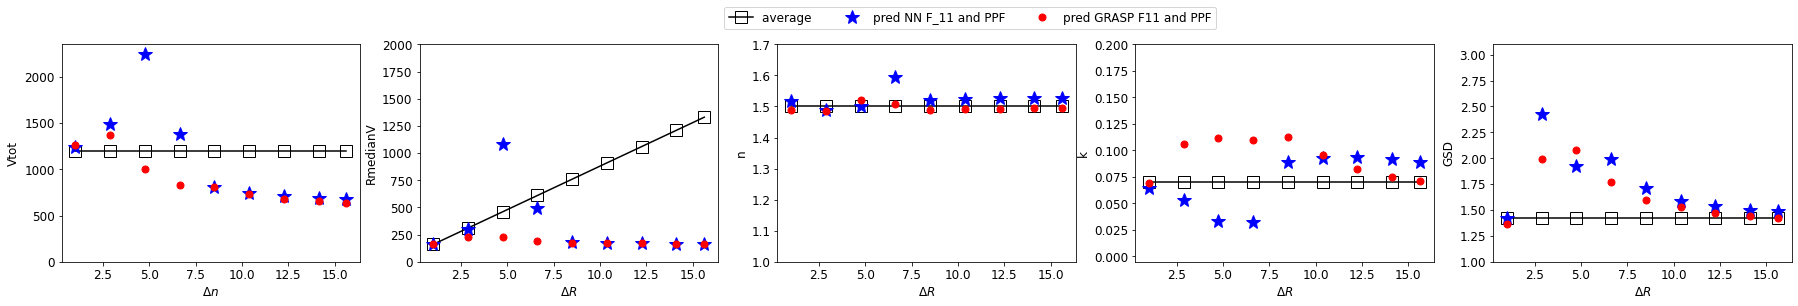

In [62]:
fs = 12
ms = 14
ms1 = 12
ms2 = 14
fsl = 15
name = 'n'

fig = plt.figure(tight_layout=True,figsize=(31,4))
gs = gridspec.GridSpec(1, 5)
number = 0
for name in dvar_test_1.columns:

    if name == 'Vtot':
        ax = fig.add_subplot(gs[0, 0])   

        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n]),'k',markersize = ms1,  marker = 's', label = 'V_tot1+V_tot2', fillstyle = 'none')
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '*',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms2 )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'red', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)

        ax.set_xlabel('$\Delta n$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)
        ax.set_ylim(0,2350)

    else:
        if name == 'RmedianV':
            ax = fig.add_subplot(gs[0, 1]) 
            ax.set_ylim(0,2000)
        if name == 'GSD':
            ax = fig.add_subplot(gs[0, 4]) 
            ax.set_ylim(1.0,3.1)
        if name == 'n':
            ax = fig.add_subplot(gs[0, 2])
            ax.set_ylim(1.0,1.7)
        if name == 'k':
            ax = fig.add_subplot(gs[0, 3])
            ax.set_ylim(-0.005,0.2)
        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n])/2.,'k', markersize = ms1,  marker = 's', label = 'average ', fillstyle='none') 
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '*',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms2 )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'red', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)
        if number == 2:
            ax.legend(fontsize = fs, loc='upper left', bbox_to_anchor=(1, 1.2), ncol = 5 )

        ax.set_xlabel('$\Delta R$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)

fig.savefig(f'{plot_dir}/case1b_changing_R_parameters.jpg')


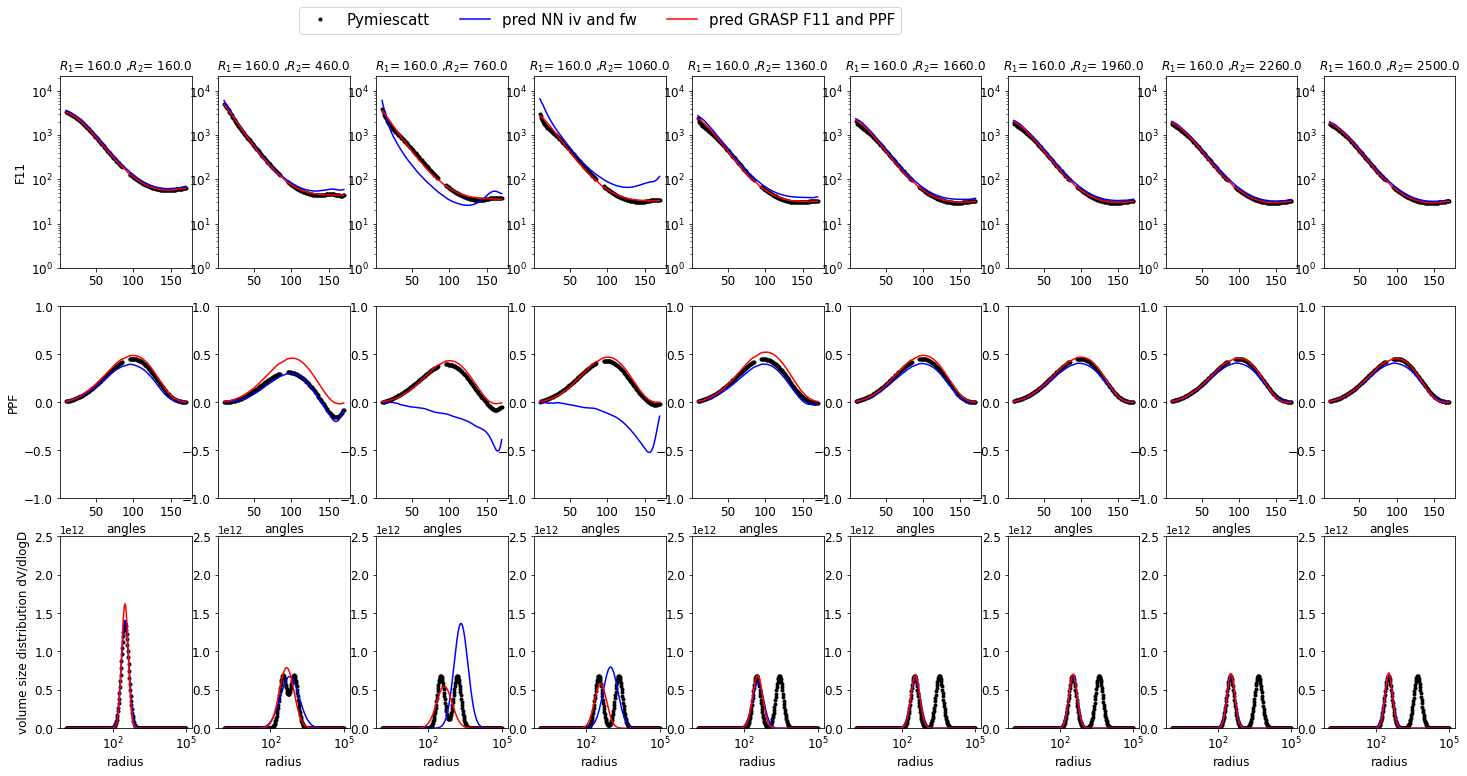

In [63]:


        
        

fig = plt.figure(figsize=(25,12))
number = 0
gs = gridspec.GridSpec(3,9)
for index in cases_n:
    ax = fig.add_subplot(gs[0,number])
    ax.plot(theta, qoi_test[F11_list].loc[index], 'k.',label='Pymiescatt')
    ax.plot(theta, qoi_pred_INN[F11_list].loc[index],'b', label='pred NN iv and fw')
    ax.plot(theta, qoi_predGRASP_F11PPF[F11_list].loc[index]*1e12/4/np.pi,color = 'r', label = 'pred GRASP F11 and PPF')

    ax.set_yscale('log')
    ax.set_ylim(1,22000)
    if number ==0:
        ax.set_ylabel('F11')
    ax.set_title('$R_1$= '+str(dvar_test_1['RmedianV'].loc[index])+' ,$R_2$= '+str(dvar_test_2['RmedianV'].loc[index]))
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    if number ==3:
        
        ax.legend(fontsize = fsl,     loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol = 5)
        
    ax = fig.add_subplot(gs[1, number])
    ax.plot(theta, qoi_test[PPF_list].loc[index], 'k.',label='Pymiescatt')
    ax.plot(theta, qoi_pred_INN[PPF_list].loc[index],'b', label='pred NN iv and  fw')
    ax.plot(theta, qoi_predGRASP_F11PPF[PPF_list].loc[index],color = 'r', label = 'pred GRASP F11 and PPF')
    ax.set_xlabel('angles')
    if number ==0:
        ax.set_ylabel('PPF')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.set_ylim(-1,1)
    
    vdvar_test_1 = compute_v(dvar_test_1.loc[index].values, D_array)
    vdvar_test_2 = compute_v(dvar_test_2.loc[index].values, D_array)
    
    vdvar_pred_final  = compute_v(dvar_pred_final.loc[index].values, D_array)       
    
    vdvar_GRASP_F11PPF = compute_v(dvar_predGRASP_F11PPF.loc[index].values, D_array)
  
  

    ax = fig.add_subplot(gs[2, number])
    ax.plot(D_array,vdvar_test_1+vdvar_test_2 ,'k.',label = 'bimodal')
    ax.plot(D_array,vdvar_pred_final,'b',label = 'pred INN F_11 and PPF')
    ax.plot(D_array, vdvar_GRASP_F11PPF,color = 'r', label = 'pred GRASP F11 and PPF')
    ax.set_ylim(0,2.5*1e12)
    ax.set_xscale('log')
    ax.set_xlabel('radius')
    if number ==0:
        ax.set_ylabel('volume size distribution dV/dlogD')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    number = number +1
# Case2 - changing n
fig.savefig(f'{plot_dir}/case1b_changing_R_all.jpg')


# Plots for Case 1c: changing R2|

In [64]:
cases_n = [24,25,26,27,28,29,30,31,32,33]
xax = (dvar_test_2['RmedianV']/dvar_test_1['RmedianV'])[24:].values

<ipython-input-65-e6b47675cc22>:52: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.savefig(f'{plot_dir}/case1c_changing_R_parameters.jpg')
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


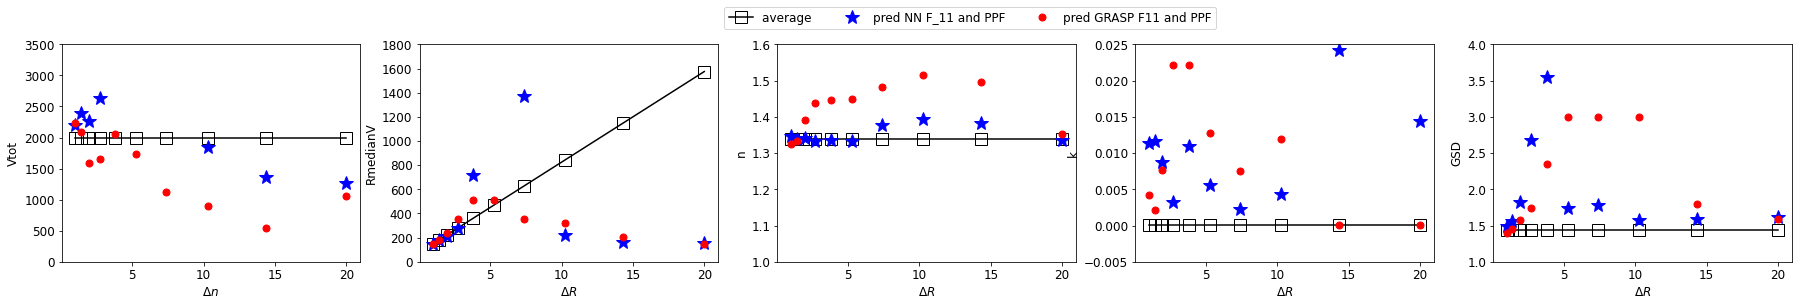

In [65]:
fs = 12
ms = 14
ms1 = 12
ms2 = 14
fsl = 15
name = 'n'

fig = plt.figure(tight_layout=True,figsize=(31,4))
gs = gridspec.GridSpec(1, 5)
number = 0
for name in dvar_test_1.columns:

    if name == 'Vtot':
        ax = fig.add_subplot(gs[0, 0])   

        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n]),'k',markersize = ms1,  marker = 's', label = 'V_tot1+V_tot2', fillstyle = 'none')
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '*',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms2 )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'red', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)

        ax.set_xlabel('$\Delta n$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)
        ax.set_ylim(0,3500)

    else:
        if name == 'RmedianV':
            ax = fig.add_subplot(gs[0, 1]) 
            ax.set_ylim(0,1800)
        if name == 'GSD':
            ax = fig.add_subplot(gs[0, 4]) 
            ax.set_ylim(1.0,4)
        if name == 'n':
            ax = fig.add_subplot(gs[0, 2])
            ax.set_ylim(1.0,1.6)
        if name == 'k':
            ax = fig.add_subplot(gs[0, 3])
            ax.set_ylim(-0.005,0.025)
        ax.plot(xax, (dvar_test_1[name].loc[cases_n]+dvar_test_2[name].loc[cases_n])/2.,'k', markersize = ms1,  marker = 's', label = 'average ', fillstyle='none') 
        number = number+1
        ax.plot(xax, dvar_pred_final[name].loc[cases_n],marker = '*',color ='b',label = 'pred NN F_11 and PPF',linestyle = 'None',markersize = ms2 )
        ax.plot(xax, dvar_predGRASP_F11PPF[name].loc[cases_n],marker = '.',color = 'red', label = 'pred GRASP F11 and PPF',linestyle = 'None',markersize = ms)
        if number == 2:
            ax.legend(fontsize = fs, loc='upper left', bbox_to_anchor=(1, 1.2), ncol = 5 )

        ax.set_xlabel('$\Delta R$', fontsize = fs)
        ax.set_ylabel(str(name), fontsize = fs)
        ax.tick_params(axis='both', which='major', labelsize=fs)
        ax.tick_params(axis='both', which='minor', labelsize=fs)

fig.savefig(f'{plot_dir}/case1c_changing_R_parameters.jpg')


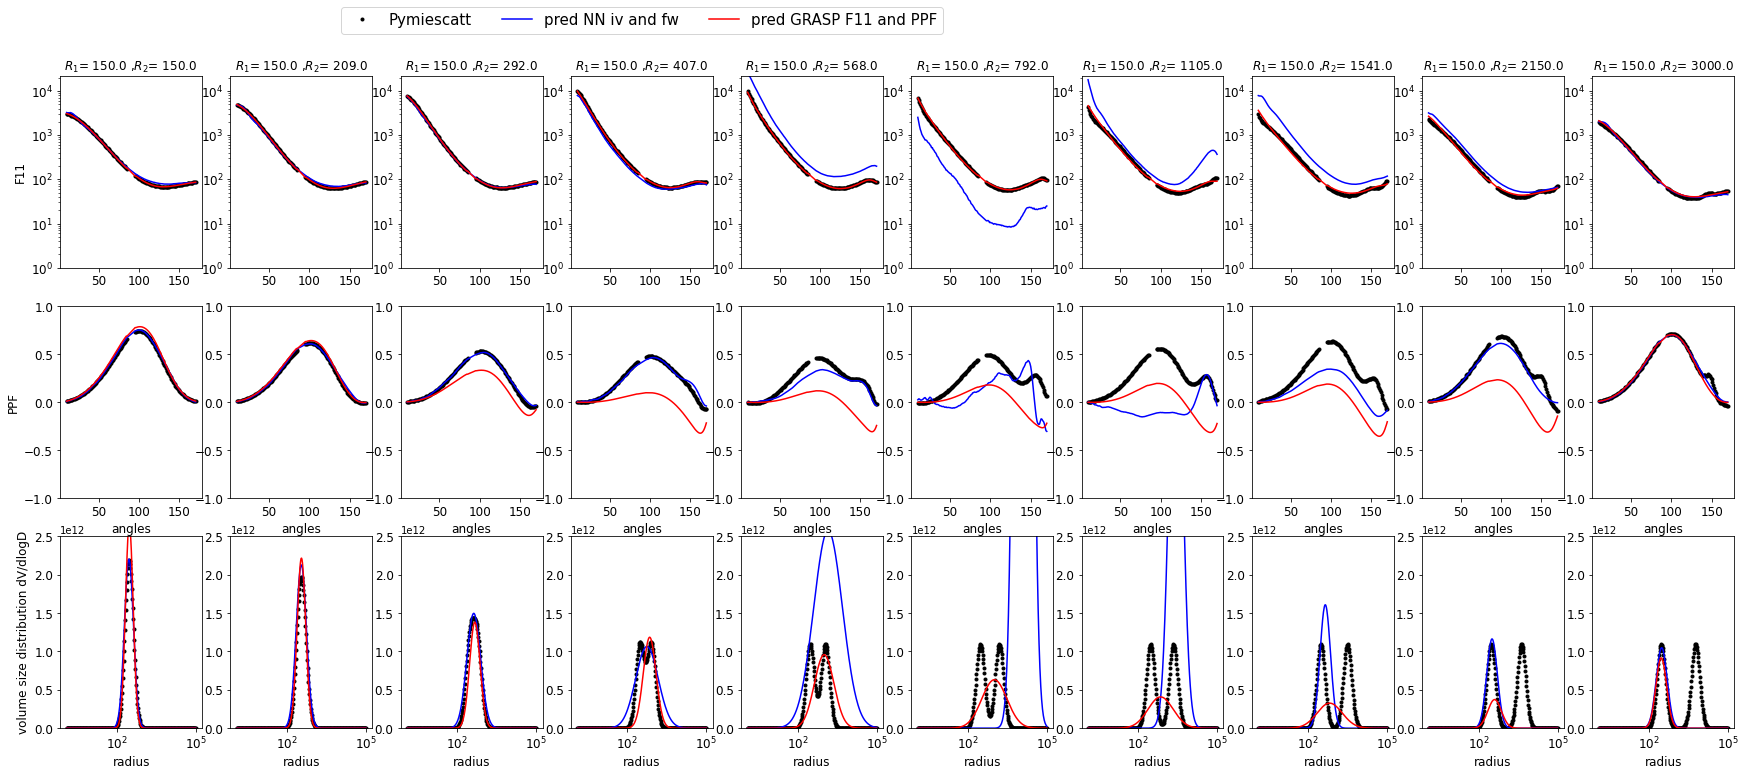

In [66]:
       
        

fig = plt.figure(figsize=(30,12))
number = 0
gs = gridspec.GridSpec(3,10)
for index in cases_n:
    ax = fig.add_subplot(gs[0,number])
    ax.plot(theta, qoi_test[F11_list].loc[index], 'k.',label='Pymiescatt')
    ax.plot(theta, qoi_pred_INN[F11_list].loc[index],'b', label='pred NN iv and fw')
    ax.plot(theta, qoi_predGRASP_F11PPF[F11_list].loc[index]*1e12/4/np.pi,color = 'r', label = 'pred GRASP F11 and PPF')

    ax.set_yscale('log')
    ax.set_ylim(1,22000)
    if number ==0:
        ax.set_ylabel('F11')
    ax.set_title('$R_1$= '+str(dvar_test_1['RmedianV'].loc[index])+' ,$R_2$= '+str(dvar_test_2['RmedianV'].loc[index]))
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    if number ==3:
        
        ax.legend(fontsize = fsl,     loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol = 5)
        
    ax = fig.add_subplot(gs[1, number])
    ax.plot(theta, qoi_test[PPF_list].loc[index], 'k.',label='Pymiescatt')
    ax.plot(theta, qoi_pred_INN[PPF_list].loc[index],'b', label='pred NN iv and  fw')
    ax.plot(theta, qoi_predGRASP_F11PPF[PPF_list].loc[index],color = 'r', label = 'pred GRASP F11 and PPF')
    ax.set_xlabel('angles')
    if number ==0:
        ax.set_ylabel('PPF')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.set_ylim(-1,1)
    
    vdvar_test_1 = compute_v(dvar_test_1.loc[index].values, D_array)
    vdvar_test_2 = compute_v(dvar_test_2.loc[index].values, D_array)
    
    vdvar_pred_final  = compute_v(dvar_pred_final.loc[index].values, D_array)       
    
    vdvar_GRASP_F11PPF = compute_v(dvar_predGRASP_F11PPF.loc[index].values, D_array)
  
  

    ax = fig.add_subplot(gs[2, number])
    ax.plot(D_array,vdvar_test_1+vdvar_test_2 ,'k.',label = 'bimodal')
    ax.plot(D_array,vdvar_pred_final,'b',label = 'pred INN F_11 and PPF')
    ax.plot(D_array, vdvar_GRASP_F11PPF,color = 'r', label = 'pred GRASP F11 and PPF')
    ax.set_ylim(0,2.5*1e12)
    ax.set_xscale('log')
    ax.set_xlabel('radius')
    if number ==0:
        ax.set_ylabel('volume size distribution dV/dlogD')
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    number = number +1
# Case2 - changing n
fig.savefig(f'{plot_dir}/case1c_changing_R_all.jpg')
